# M.Sc. Data Science Thesis
# Graph Neural Networks for Twitter Data
# Sultan Beishenkulov (1482117)

Link prediction refers to inferring the future relationships from nodes in a complex network, or more formally, estimating the likelihood of the existence of a link between two nodes based on the observed network structure and node attributes (Martinčić-Ipsˇić S, Močibob E, Perc M, 2017).

As a practical part of Master's thesis, I will build and test a GNN model (GraphSage) using Twitter data obtained with Tweepy, to execute link prediction (i.e., to predict future Twitter connections).

### Project roadmap:
1.   Scrape the Twitter network using Tweepy
2.   Create and visualize the graph using NetworkX
3.   Build and test a GNN model for Twitter link prediction using GraphSage
4.   Conclusion
5.   References

## 1. The Dataset: scraping Twitter with Tweepy

In this project, I use the Tweepy library to scrape Twitter. 

To start, I retrieve 100 tweets with the hashtag "#python" to get the first nodes of the graph. I consider the hashtag a shared trait of the community, e.g., python developers.

Next, I identify the authors of the 100 tweets and retrieve the users they follow. This way, I can build a network with enough data points for the link prediction task.


In [ ]:
# Import libs
import tweepy # https://github.com/tweepy/tweepy
import pandas as pd
import numpy as np
import csv
import time
import sys

In [ ]:
# Twitter API Credentials
#There should be the API keys, I deleted my personal keys.

consumer_key = 
consumer_secret = 
access_key = 
access_secret = 

OAUTH_KEYS = {'consumer_key':consumer_key, 'consumer_secret':consumer_secret,
 'access_token_key':access_key, 'access_token_secret':access_secret}
auth = tweepy.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
# Retrieve 100 tweets using the hashtag "#python"
search = tweepy.Cursor(api.search, q='#python').items(100)

In [ ]:
# Build lists for each field desired from the tweets (i.e., user names and tweets).
sn = []
text = []
timestamp =[]
for tweet in search:
    sn.append(tweet.user.screen_name)
    text.append(tweet.text)

In [ ]:
# Convert the lists to dataframe
df = pd.DataFrame()
df['sn'] = sn
df['text'] = text

In [ ]:
# Store Tweets in a file so I don't need to scrape them every time.
df.to_csv('pythontweets.csv', index = False, encoding='utf-8')

In [ ]:
# Build a list of the unique usernames to determine which users I need to retrieve friends for.
allNames = list(df['sn'].unique())
len(allNames)

56

In [ ]:
# Now, having a list of all of the authors of the tweets, I can retrive who their are following to build our social graph.

# Initialize dataframe of users that will hold the edge relationships
dfUsers = pd.DataFrame()
dfUsers['userFromName'] =[]
dfUsers['userFromId'] =[]
dfUsers['userToId'] = []
count = 0 

In [ ]:
# I choose to retrieve friends (who the user is following) rather than followers to avoid larger calls to the Twitter API (as large accounts may have huge followings).
# It still may take long to run, though (when I run it, it took around 1h)
# To avoid reaching the API rate limit, a timeout is built into every iteration.

nameCount = len(allNames)

for name in allNames:
    
    # Build list of friends
    currentFriends = []
    for page in tweepy.Cursor(api.friends_ids, screen_name=name).pages():
        currentFriends.extend(page)
    currentId = api.get_user(screen_name=name).id
    currentId = [currentId] * len(currentFriends)
    currentName = [name] * len(currentFriends)   
    dfTemp = pd.DataFrame()
    dfTemp['userFromName'] = currentName
    dfTemp['userFromId'] = currentId
    dfTemp['userToId'] = currentFriends
    dfUsers = pd.concat([dfUsers,dfTemp]) # dataframe that will be used to build the NetworkX graph
    time.sleep(70) # timeout to avoid hitting Twitter rate limit
    
    # Progress bar to track approximate progress
    count +=1
    per = round(count*100.0/nameCount,1)
    sys.stdout.write("\rTwitter call %s%% complete." % per)
    sys.stdout.flush()

Twitter call 19.6% complete.

Twitter call 62.5% complete.

Twitter call 100.0% complete.

In [ ]:
# Store the Pandas DataFrame with the users in a file so I don't need to scrape them every time.

dfUsers.to_csv('dfUsers.csv',index = False,encoding='utf-8')

## 2. The Social Graph: creating and visualizing the graph with NetworkX.

After some data wrangling, I use the NetworkX library to build the graph that will feed the Graph Neural Network in the link prediction task.

Then, I make a visualization of the graph.

In [ ]:
import networkx as nx

# Data wrangling
df = pd.read_csv('/content/dfUsers.csv', sep=',', names=['userFromId', 'userToId'])
# cut dataframe to avoid running out of GPU memory in the next operations
df = df.iloc[-20000: , :] 
df.reset_index(drop=True, inplace=True)

# Convert user ID from float to integer.
df.userFromId=df.userFromId.apply(lambda x: int(float(x)))
df.userToId=df.userToId.apply(lambda x: int(float(x)))

In [ ]:
df

,userFromId,userToId
0,1095113346242830336,377715836
1,1095113346242830336,565962173
2,1095113346242830336,576538615
3,1095113346242830336,31632509
4,1095113346242830336,807651296
...,...,...
19995,4784927239,262957888
19996,4784927239,2675566094
19997,4784927239,397823080
19998,4784927239,129719649


In [ ]:
# Build the Networkx Graph
G = nx.Graph()
G.add_nodes_from(df['userFromId'])
temp = zip(df['userFromId'],df['userToId'])
G.add_edges_from(temp)
print(nx.info(G))

Graph with 15007 nodes and 15470 edges


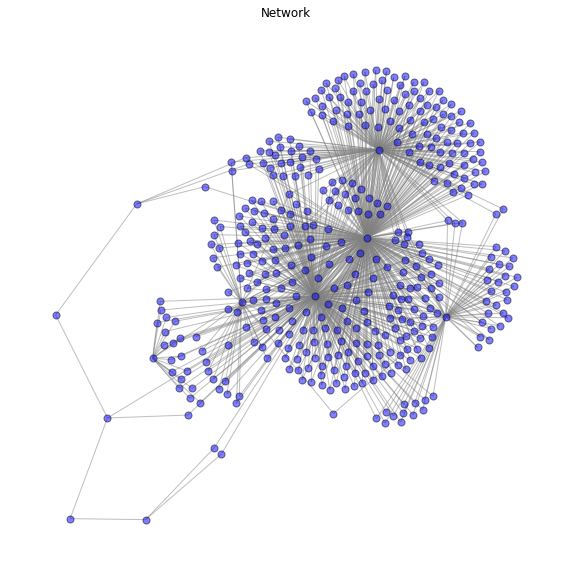

In [ ]:
# Visualize the Graph

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

G_minor = nx.k_core(G, 2) # Show only nodes with degree >= 2 to reduce plotting time (subgraph)

# Define positioning and other visualization parameters
pos_fr = nx.spring_layout(G_minor)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.figure()
plt.axis("off")
plt.title('Network')

# Draw subgraph
nx.draw_networkx(G_minor, pos=pos_fr, node_size=50, node_color='blue', edge_color='gray', alpha=0.5, with_labels=False, edgecolors='black')

## 3. The GNN Model: Twitter link prediction using  the Stellargraph GraphSAGE

In this final section, I use the Twitter data I have collected and the graph I have built to train a GraphSage GNN model. 

I treat the problem with supervised learning. Pairs of nodes are inputs to the algorithm, and the output is binary (connected or unconnected).

GraphSAGE needs node features to work, which may or may not be available in a dataset. In our case, to avoid using real node features, which are sparse on the Twitter network and somewhat laborious to obtain using Tweepy, I create an Identity Matrix and attribute its elements as "fake features" to the nodes. That is, I assign each node a one-hot encoded vector of length equal to the number of nodes in the graph, where only the cell corresponding to the given node is 1, while the remaining cells are 0.

Finally, I assess the model's performance in predicting future Twitter connections (link prediction task).

In [ ]:
!pip install stellargraph

In [ ]:
# Create training and test sets with scikit-learn and StellarGraph
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

** Sampled 1547 positive and 1547 negative edges. **
** Sampled 1392 positive and 1392 negative edges. **


In [ ]:
# Create Identity Matrix (one-hot encoded vectors of
# length equal to the number of nodes in the train_graph)
eye = np.eye(graph_train.number_of_nodes())
eye

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# Create an array of nodes to help attributing the fake features
keys1 = nx.to_pandas_edgelist(G)["source"]
keys2 = nx.to_pandas_edgelist(G)["target"]
keys = pd.concat([keys1, keys2]).unique()
keys

array([1095113346242830336,            91896001,  738752276836306944, ...,
                 397823080,           129719649,          4321707150])

In [ ]:
# Create a dictionary to help attributing the fake features (the nodes are the keys and the vectors in the Identity Matrix are the values)
fake_features = dict(zip(keys, eye.T))

In [ ]:
# Attribute the fake features to the nodes of the training set
nx.set_node_attributes(graph_train, fake_features, "fake")

In [ ]:
# Check if the (fake) feature was successfully attributed to a node
graph_train.nodes[4784927239]

{'fake': array([0., 0., 0., ..., 0., 0., 0.])}

In [ ]:
# Repeat the last steps to the testing set (creating and attributing "fake features")
eye = np.eye(graph_test.number_of_nodes())
fake_features = dict(zip(keys, eye.T))
nx.set_node_attributes(graph_test, fake_features, "fake")

In [ ]:
# Use StellarGraph to store graph information from NetworkX object and features for machine learning

from stellargraph.mapper import GraphSAGELinkGenerator

# Batch size to be sent to GPU
batch_size = 64
num_samples = [4, 4]

# Create StellarGraphs with fake feature vectors and test and train flows
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [ ]:
# Create GraphSage model

from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

# Two hidden layers with size 20
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.5
)

x_inp, x_out = graphsage.in_out_tensors()

# Classification layer using the inner product method to produce edge embeddings and feed the classification head
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

# Optimizer: Adam, Learning rate: 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [ ]:
# Train Model. Epochs: 6
epochs = 6
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/6
44/44 [==============================] - 40s 857ms/step - loss: 0.2375 - acc: 0.5686 - val_loss: 0.2164 - val_acc: 0.6687
Epoch 2/6
44/44 [==============================] - 37s 847ms/step - loss: 0.2169 - acc: 0.6774 - val_loss: 0.2024 - val_acc: 0.7275
Epoch 3/6
44/44 [==============================] - 39s 890ms/step - loss: 0.2036 - acc: 0.7446 - val_loss: 0.1960 - val_acc: 0.7637
Epoch 4/6
44/44 [==============================] - 37s 840ms/step - loss: 0.1961 - acc: 0.7690 - val_loss: 0.1932 - val_acc: 0.7770
Epoch 5/6
44/44 [==============================] - 37s 840ms/step - loss: 0.1906 - acc: 0.7884 - val_loss: 0.1905 - val_acc: 0.8061
Epoch 6/6
44/44 [==============================] - 38s 860ms/step - loss: 0.1876 - acc: 0.7895 - val_loss: 0.1885 - val_acc: 0.7993


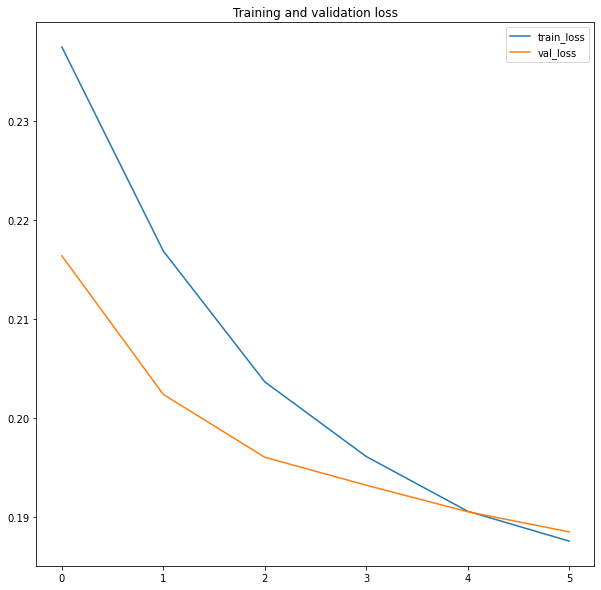

In [ ]:
# Plot loss curves (training and validation)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.title('Training and validation loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
# Performance metrics

from sklearn.metrics import classification_report
y_pred = np.round(model.predict(test_flow)).flatten()
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1547
           1       0.73      0.95      0.83      1547

    accuracy                           0.80      3094
   macro avg       0.83      0.80      0.80      3094
weighted avg       0.83      0.80      0.80      3094



## 4. Conclusion

In this project, I have built and tested a GNN model (GraphSage) using Twitter data obtained with Tweepy, to execute link prediction (i.e., to predict future Twitter connections). Without using any real node features, I managed to achieve an accuracy of 80% on the testing set. 

For instance, if I could predict future connections on Twitter with 80% accuracy, I would be able to make reasonable friendship recommendations to its users. Furthermore, according to Obviously.AI, an accuracy between 70%-90% is consistent with industry standards.

## 5. References

C. Stamile, A. Marzullo, E. Deusebio (2021). **Graph Machine Learning**. Github: https://github.com/PacktPublishing/Graph-Machine-Learning/blob/main/Chapter06/01_Social_network_analysis.ipynb

Martinčić-Ipsˇić S, Močibob E, Perc M
(2017). **Link prediction on Twitter**. PLoS ONE 12(7):
e0181079. https://doi.org/10.1371/journal.
pone.0181079

Obviously.AI (2022). **How To Know if Your Machine Learning Model Has Good Performance**. https://www.obviously.ai/post/machine-learning-model-performance
